# PA005: High Value Customer Identification (Insiders)

## 0.0 Planejamento da solução (IOT)

### Input - Entrada

1. Problema de negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelidade 
2. Conjunto de dados
    - Venda de um ecommerce online, durante período de um ano

### Output - Saída

1. Indicação das pessoas que farão parte do programa Insiders
    - Lista:    client id | is_insider |
            4967        yes
            5488        no
2. Relatório com as respostas das perguntas de negócio
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento que vem do Insiders?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível ao Insiders?
    - Quais as condições para uma pessoa ser removida do Insiders?
    - Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Quais ações o time de marketing pode fazer para aumentar o faturamento?

### Tasks - Tarefas

   1. Quem são as pessoas elegíveis para participar do programa Insiders?
       - O que são clientes mais valiosos para a empresa?
       - Faturamento
           - Alto ticket médio
           - Alto LTV (a soma de tudo que a pessoa gastou)
           - Baixa recência
           - Alto basket size
           - Baixa probabilidade de churn
           - Alta previsão de LTV
           - Alta propensão de compra
       - Custo
           - Baixa taxa de devolução
       - Experiência de compra
           - Média alta nas avaliações
   
   2. Quantos clientes farão parte do grupo?
       - Número total de clientes
       - % do grupo Insiders
   
   3. Quais as principais características desses clientes?
       - Escrever características do cliente
           - Idade
           - Localização
       - Escrever características do consumo
           - Features/atributos da clusterização
   
   4. Qual a porcentagem de contribuição do faturamento que vem do Insiders?
       - Faturamento total do ano
       - Faturamento do grupo Insiders
   
   5. Qual a expectativa de faturamento desse grupo para os próximos meses?
       - LTV do grupo Insiders
       - Análise de cohort
   
   6. Quais as condições para uma pessoa ser elegível ao Insiders?
       - Definir periodicidade (exemplo: 1 mês, 3 meses)
       - A pessoa precisa ser similar com uma pessoa do grupo
   
   7. Quais as condições para uma pessoa ser removida do Insiders?
       - Definir periodicidade (exemplo: 1 mês, 3 meses)
       - A pessoa precisa ser desimilar com uma pessoa do grupo
   
   8. Qual a garantia que o programa Insiders é melhor que o restante da base?
       - Teste A/B
       - Teste A/B Bayesiano
       - Teste de hipótese
   
   9. Quais ações o time de marketing pode fazer para aumentar o faturamento?
       - Desconto
       - Preferência de compra
       - Frete
       - Visita à empresa

## 0.0. Imports

In [1]:
import umap
import warnings
import pandas  as pd
import numpy   as np
import seaborn as sns

from matplotlib            import pyplot        as plt
from sklearn               import cluster       as c
from sklearn               import metrics       as m
from plotly                import express       as px
from sklearn               import decomposition as dd
from sklearn               import ensemble      as en 
from sklearn.manifold      import TSNE 

from IPython.display       import HTML
from sklearn.preprocessing import MinMaxScaler
from pandas_profiling      import ProfileReport
from yellowbrick.cluster   import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
def isnumber(value):
    try:
        int(value)
    except ValueError:
        return False
    return True

In [5]:
warnings.filterwarnings("ignore")

## 0.2. Loading dataset

In [6]:
pwd

'C:\\Users\\aline.moraes\\Documents\\Aprendizado_continuo\\Comunicade_DS\\insiders_clustering\\notebook'

In [7]:
# load data
df_raw = pd.read_csv('Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw.drop(['Unnamed: 8'], axis=1, inplace=True)

In [8]:
df_raw.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.0. Descrição dos dados

In [9]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [10]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

In [12]:
df1.columns = cols_new
df1.head(2)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.2. Data Dimensios

In [13]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types

In [14]:
df1.info()

# invoice_no e stock_code deveriam ser int
# invoice_date deveria ser datetime
# customer_id deveria ser int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 1.4. Check NA

In [15]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [16]:
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[~df1['customer_id'].isna()]

In [17]:
df_missing.shape

(135080, 8)

In [18]:
df_not_missing.shape

(406829, 8)

In [19]:
# vamos identificar se há invoice_no iguais na df_missing e na df_not_missing, pq se sim, conseguiríamos recuperar os customers_id
# como não temos, vamos usar outra estratégia para não apenas dropar os customers_id com NA: 
# vamos criar ids para os customers_id nulos de acordo com os invoice numbers

df_not_missing[df_not_missing['invoice_no'].isin(df_missing['invoice_no'].drop_duplicates().to_list())]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [20]:
df_not_missing['customer_id'].max()

18287.0

In [21]:
# Create reference

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge original with reference database

df1 = df1.merge(df_backup, how='left', on='invoice_no')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra columns
df1 = df1.drop(['customer_id_x', 'customer_id_y'], axis=1)

In [22]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   country       541909 non-null  object 
 7   customer_id   541909 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [24]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date']) #format='%Y-%m-%d'

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int) 

# Alteração do invoice_no e stock_code tem letras misturadas com os números, vamos tratar mais para frente

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   country       541909 non-null  object        
 7   customer_id   541909 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 35.1+ MB


## 1.7. Descriptive Statistics

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   country       541909 non-null  object        
 7   customer_id   541909 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 35.1+ MB


In [26]:
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'int32', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [27]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns=['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.1.1 Numerical Attributes Investigating

1. Quantidade negativa
2. Preço unitário igual a zero

In [28]:
df1[df1['quantity'] <= 0].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548


In [29]:
rows = df1[df1['quantity'] <= 0].shape[0]
print(f'{rows} registros com quantidade < 0\nAlguns estão como Discont na descrição e outros com C no início de invoice, indicando um possível cancelamento/cancel ou alteração/change')

10624 registros com quantidade < 0
Alguns estão como Discont na descrição e outros com C no início de invoice, indicando um possível cancelamento/cancel ou alteração/change


In [30]:
df1[df1['unit_price'] == 0].sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
404951,571704,23579,Sale error,4,2017-10-16,0.0,United Kingdom,22061
323872,565370,82494L,crushed ctn,-33,2017-08-31,0.0,United Kingdom,21639
20398,538045,84688,NaN,27,2016-12-07,0.0,United Kingdom,19146
20399,538046,85008,NaN,-15,2016-12-07,0.0,United Kingdom,19147
373013,569256,20774,damaged,-14,2017-10-01,0.0,United Kingdom,21867


In [31]:
rows = df1[df1['unit_price'] == 0].shape[0]
print(f'{rows} registros com preço igual a zero\nAlguns estão como Manual na descrição, mas a maioria apresenta informações coerentes em invoice_no, stock_code e description')

2515 registros com preço igual a zero
Alguns estão como Manual na descrição, mas a maioria apresenta informações coerentes em invoice_no, stock_code e description


In [32]:
#ainda há valores bem pequenos como $ 0.001 e com o stock_code apenas com string
df1[df1['unit_price'] > 0.0].sort_values('unit_price', ascending=True).head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,United Kingdom,13952
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-07-24,0.001,United Kingdom,15618
361741,568375,BANK CHARGES,Bank Charges,1,2017-09-24,0.001,United Kingdom,13405
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.001,United Kingdom,16198
108088,C545478,D,Discount,-720,2017-03-01,0.010,United Kingdom,16422


### 1.7.2 Categorical Attributes

In [33]:
cat_attributes.sample(3)

# invoice_no e stock_code não deveriam estar como categórico, mas estão pq há alguns registros com letras

,invoice_no,stock_code,description,country
93618,544303,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
6706,536975,21912,VINTAGE SNAKES & LADDERS,EIRE
162863,550521,84879,ASSORTED COLOUR BIRD ORNAMENT,United Kingdom


In [34]:
cat_attributes['check_invoice_no'] = cat_attributes['invoice_no'].apply(isnumber)
cat_attributes['check_stock_code'] = cat_attributes['stock_code'].apply(isnumber)

In [35]:
cat_attributes[cat_attributes['check_invoice_no'] == False].shape[0]

# número de registros em invoice_no que tem pelo menos 1 letra

9291

In [36]:
cat_attributes[cat_attributes['check_stock_code'] == False].shape[0]

# número de registros em stock_code que tem pelo menos 1 letra

54873

In [37]:
cat_attributes.shape[0]

# número total de registros

541909

In [38]:
# itens em stock_code que apresentam só letras

df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code' ].unique()

# na regex, [a-zA-Z] significa que quero qualquer valor de a-z ou A-Z 
# não quero só um valor, eu quero mais de um valor, por isso o +
# como não quero letras só no meio e sim que a string comece e termine com letras, acrescentamos ^ no início e $ no final

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [39]:
# country

df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [40]:
# Vamos substituir os country por lat/long com os dados do arquivo https://developers.google.com/public-data/docs/canonical/countries_csv
# Remover: European Community e Unspecified
# Trocar USA, EIRE e RSA por United States, X e South Africa, respectivamente  

## 2.0. Filtragem de Variáveis

In [41]:
df2 = df1.copy()

In [42]:
# Numerical attributes

df2 = df2[(df2['quantity'] > 0) & (df2['unit_price'] > 0.04)]

# Categorical attributes

itens = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(itens)]

# Description: vamos remover pq não agregará ao modelo
df2 = df2.drop('description', axis=1)

# Country
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

## 3.0. Feature Engineering

In [43]:
df3 = df2.copy()

## 3.1. Feature Creation

In [44]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


In [45]:
# data reference
# como o objetivo é clusterizar nossos clientes, o df_ref terá os unique customers_id 

df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [46]:
print(f'Temos {df_ref.shape[0]} clientes na base')

Temos 5701 clientes na base


### 3.1.1 Monetary

In [47]:
# Gross Revenue (quantity*price = Faturamento)
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

In [48]:
# Monetary
df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_monetary.head()

,customer_id,gross_revenue
0,12346,77183.60
1,12347,4310.00
2,12348,1437.24
3,12349,1457.55
4,12350,294.40


In [49]:
df_ref = df_ref.merge(df_monetary, how='left', on='customer_id')
df_ref.head()

,customer_id,gross_revenue
0,17850,5391.21
1,13047,3232.59
2,12583,6705.38
3,13748,948.25
4,15100,876.00


### 3.1.2 Recency

In [50]:
# registro mais recente do dataset
df3['invoice_date'].max()

Timestamp('2017-12-07 00:00:00')

In [51]:
# Recency (last day purchase)
df3['recency_in_days'] = (df3['invoice_date'].max() - df3['invoice_date']).dt.days
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,gross_revenue,recency_in_days
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850,15.30,373
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850,20.34,373
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850,22.00,373
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850,20.34,373
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850,20.34,373


In [52]:
df_recency = df3[['customer_id', 'recency_in_days']].groupby('customer_id').min().reset_index()
df_recency.head()

,customer_id,recency_in_days
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


In [53]:
df_ref = df_ref.merge(df_recency, how='left', on='customer_id')
df_ref.head()

,customer_id,gross_revenue,recency_in_days
0,17850,5391.21,372
1,13047,3232.59,56
2,12583,6705.38,2
3,13748,948.25,95
4,15100,876.00,333


### 3.1.3 Quantity

In [54]:
#Quantos produtos já comprou com a gente

df_quantity = df3[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_quantity.columns = ['customer_id', 'quantity']
df_quantity.head()

,customer_id,quantity
0,12346,74215
1,12347,2458
2,12348,2332
3,12349,630
4,12350,196


In [55]:
df_ref = df_ref.merge(df_quantity, how='left', on='customer_id')
df_ref.head()

,customer_id,gross_revenue,recency_in_days,quantity
0,17850,5391.21,372,1733
1,13047,3232.59,56,1390
2,12583,6705.38,2,5028
3,13748,948.25,95,439
4,15100,876.00,333,80


### 3.1.4 Purchases / quantity of invoices

In [56]:
#Quantas compras o cliente já realizou

df_purchases = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_purchases.columns = ['customer_id', 'purchases']
df_purchases.head()

,customer_id,purchases
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [57]:
df_ref = df_ref.merge(df_purchases, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency_in_days,quantity,purchases
0,17850,5391.21,372,1733,34
1,13047,3232.59,56,1390,9
2,12583,6705.38,2,5028,15
3,13748,948.25,95,439,5
4,15100,876.00,333,80,3


### 3.1.5 Avg Ticket

In [58]:
df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = df_ref.merge(df_avg_ticket, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency_in_days,quantity,purchases,avg_ticket
0,17850,5391.21,372,1733,34,18.152222
1,13047,3232.59,56,1390,9,18.904035
2,12583,6705.38,2,5028,15,28.902500
3,13748,948.25,95,439,5,33.866071
4,15100,876.00,333,80,3,292.000000


### 3.1.6 Avg Recency Days

In [59]:
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'])
df_aux['previous_customer_id'] = df_aux['customer_id'].shift() # move to the line below
df_aux['previous_invoice_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_invoice_date']).days if x['customer_id'] == x['previous_customer_id'] else
            np.nan, axis=1) # if customer_id = previous_customer_id then the difference between the purchases is calculated

df_aux = df_aux.drop(['invoice_date', 'previous_customer_id', 'previous_invoice_date'], axis=1).dropna()

# averge recency
df_avg_recency_days = df_aux.groupby(['customer_id']).mean().reset_index()

# merge
df_ref = df_ref.merge(df_avg_recency_days, how='left', on='customer_id')
df_ref.head() 

,customer_id,gross_revenue,recency_in_days,quantity,purchases,avg_ticket,avg_recency_days
0,17850,5391.21,372,1733,34,18.152222,1.000000
1,13047,3232.59,56,1390,9,18.904035,52.833333
2,12583,6705.38,2,5028,15,28.902500,26.500000
3,13748,948.25,95,439,5,33.866071,92.666667
4,15100,876.00,333,80,3,292.000000,20.000000


In [60]:
df_ref.isna().sum()

customer_id            0
gross_revenue          0
recency_in_days        0
quantity               0
purchases              0
avg_ticket             0
avg_recency_days    2927
dtype: int64

### 3.1.7 Frequency Purchase

In [61]:
# entre o primeiro e último dia de compra do cliente, quantas compras ele fez?
df_frequency_purchase = df3[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby(['customer_id']).agg(max_ = ('invoice_date', 'max'), 
                                                                                             min_ = ('invoice_date', 'min'),
                                                                                             days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1 ),
                                                                                             buy_ = ('invoice_no', 'count')).reset_index() # calculate min and max invoice_date and how many products the customer bought

df_frequency_purchase['frequency'] = df_frequency_purchase[['days_', 'buy_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] >0 else 0, axis=1)

df_ref = df_ref.merge(df_frequency_purchase, how='left', on='customer_id')
df_ref.head()

,customer_id,gross_revenue,recency_in_days,quantity,purchases,avg_ticket,avg_recency_days,max_,min_,days_,buy_,frequency
0,17850,5391.21,372,1733,34,18.152222,1.000000,2016-11-30,2016-11-29,2,34,17.000000
1,13047,3232.59,56,1390,9,18.904035,52.833333,2017-10-12,2016-11-29,318,9,0.028302
2,12583,6705.38,2,5028,15,28.902500,26.500000,2017-12-05,2016-11-29,372,15,0.040323
3,13748,948.25,95,439,5,33.866071,92.666667,2017-09-03,2016-11-29,279,5,0.017921
4,15100,876.00,333,80,3,292.000000,20.000000,2017-01-08,2016-11-29,41,3,0.073171


In [62]:
df_frequency_purchase.sort_values('frequency', ascending=False).head()

,customer_id,max_,min_,days_,buy_,frequency
4008,17850,2016-11-30,2016-11-29,2,34,17.0
2762,16120,2017-10-09,2017-10-09,1,4,4.0
2621,15920,2017-07-06,2017-07-06,1,3,3.0
4220,18139,2017-11-20,2017-11-19,2,6,3.0
2673,16000,2017-12-05,2017-12-05,1,3,3.0


## 4.0. EDA (Exploratory Data Analysis)

In [63]:
df_ref.head(2)

,customer_id,gross_revenue,recency_in_days,quantity,purchases,avg_ticket,avg_recency_days,max_,min_,days_,buy_,frequency
0,17850,5391.21,372,1733,34,18.152222,1.000000,2016-11-30,2016-11-29,2,34,17.000000
1,13047,3232.59,56,1390,9,18.904035,52.833333,2017-10-12,2016-11-29,318,9,0.028302


In [64]:
df_ref.isna().sum()

customer_id            0
gross_revenue          0
recency_in_days        0
quantity               0
purchases              0
avg_ticket             0
avg_recency_days    2927
max_                   0
min_                   0
days_                  0
buy_                   0
frequency              0
dtype: int64

In [65]:
df4 = df_ref.dropna()
df4 = df4.drop(['max_', 'min_', 'days_', 'buy_'], axis=1)

## 4.1. Univariate Analysis

1. Métricas:
    - Mín, max e range
    - Média e mediana
    - Desvio padrão e variância
    - Coeficiente de variação (CV): desvio padrão / média para identificar a dispersão dos dados em relação à média
    - Distribuição
    
Vamos olhar essas métricas para cada feature no ProfileReport a fim de entendê-las melhor e identificar outliers

In [66]:
profile = ProfileReport (df4)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [67]:
# Gross revnue

df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_in_days,quantity,purchases,avg_ticket,avg_recency_days,frequency
952,14646,279138.02,1,196844,72,135.503893,8.022727,0.203390
463,18102,259657.30,0,64124,60,602.453132,14.680000,0.163043
405,17450,194550.79,8,69993,46,577.302047,13.807692,0.127778
3266,16446,168472.50,0,80997,2,56157.500000,205.000000,0.009709
65,14911,140438.72,1,79963,199,24.768734,2.861538,0.533512


In [68]:
# Avg ticket

df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_in_days,quantity,purchases,avg_ticket,avg_recency_days,frequency
3266,16446,168472.5,0,80997,2,56157.5,205.0,0.009709


In [69]:
df1[df1['customer_id'] == 16446] # num próximo ciclo poderíamos criar uma feature qtd devolução / qtd compras para identificar clientes que devolvem muito

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446


## 4.2. Bivariate Analysis

In [70]:
df4.head(2)

,customer_id,gross_revenue,recency_in_days,quantity,purchases,avg_ticket,avg_recency_days,frequency
0,17850,5391.21,372,1733,34,18.152222,1.000000,17.000000
1,13047,3232.59,56,1390,9,18.904035,52.833333,0.028302


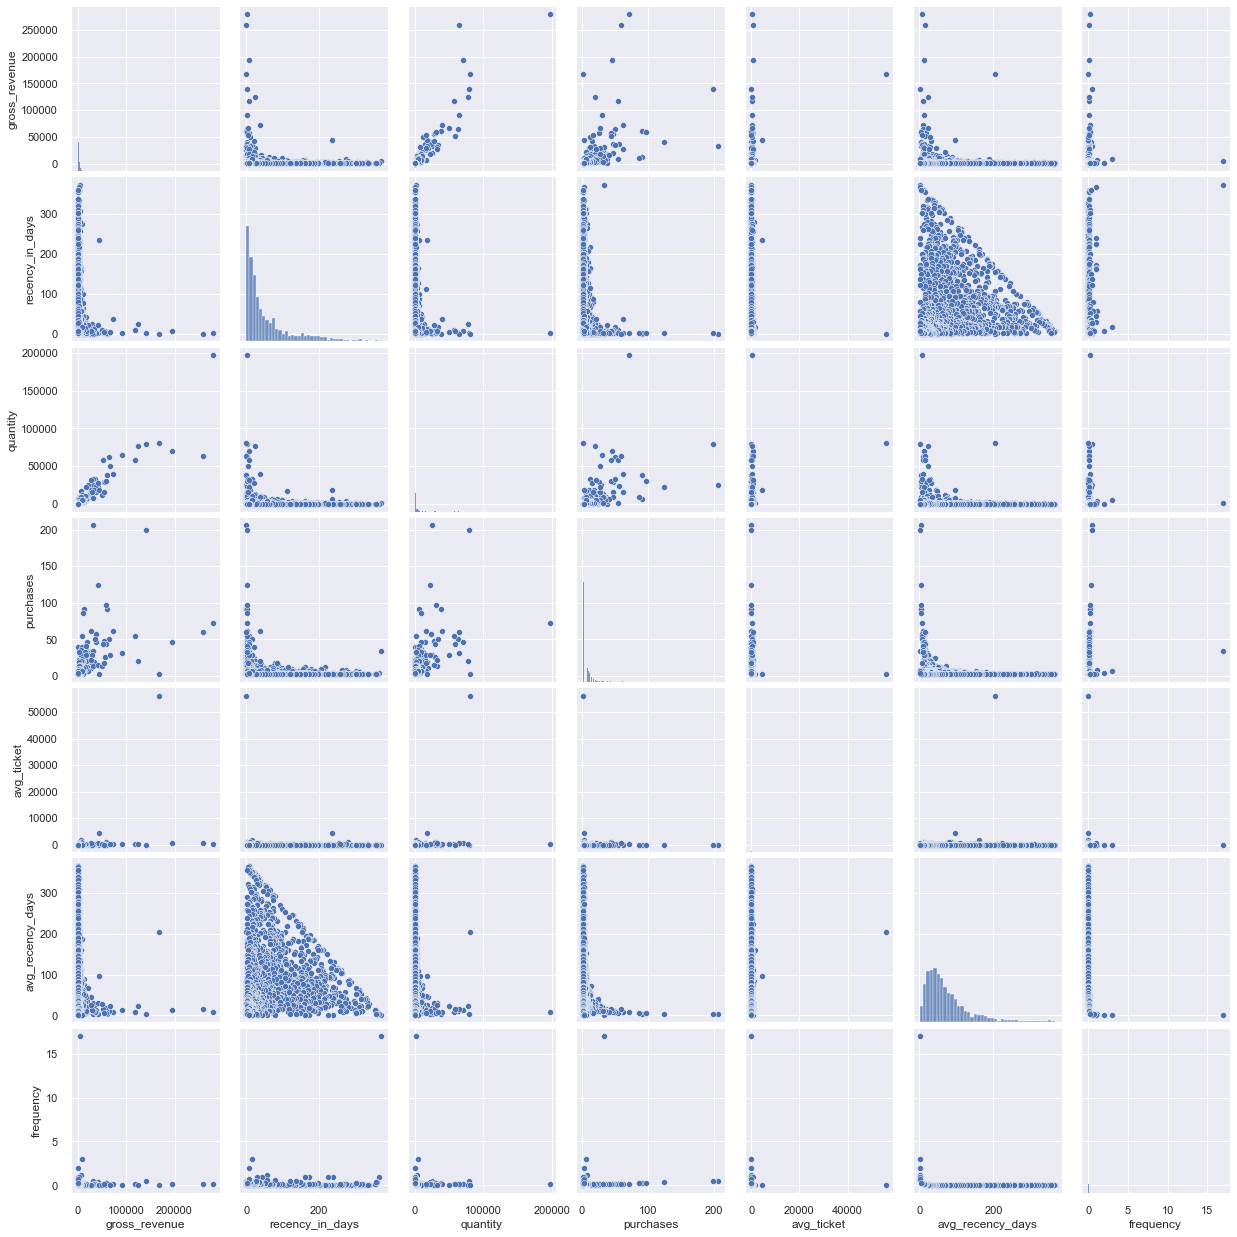

In [71]:
sns.pairplot(df4.drop(['customer_id'], axis=1))

# avg_ticket e frequency apresentam pouca variabilidade com as demais features, então talvez não sejam boas para a clusterização

## 4.3. Estudo do Espaço

In [72]:
df43 = df4.drop(['customer_id'], axis=1)

In [73]:
mms = MinMaxScaler()

df43['gross_revenue']   =  mms.fit_transform( df43[['gross_revenue']].values )
df43['recency_in_days'] =  mms.fit_transform( df43[['recency_in_days']].values )
df43['quantity'] =         mms.fit_transform( df43[['quantity']].values )
df43['purchases'] =        mms.fit_transform( df43[['purchases']].values )
df43['avg_ticket'] =       mms.fit_transform( df43[['avg_ticket']].values )
df43['avg_recency_days'] = mms.fit_transform( df43[['avg_recency_days']].values )
df43['frequency'] =        mms.fit_transform( df43[['frequency']].values )

X = df43.copy()

In [74]:
X.head()

,gross_revenue,recency_in_days,quantity,purchases,avg_ticket,avg_recency_days,frequency
0,0.019185,1.000000,0.008794,0.156863,0.000285,0.000000,1.000000
1,0.011451,0.150538,0.007051,0.034314,0.000298,0.142009,0.001345
2,0.023894,0.005376,0.025533,0.063725,0.000476,0.069863,0.002052
3,0.003267,0.255376,0.002220,0.014706,0.000565,0.251142,0.000734
4,0.003008,0.895161,0.000396,0.004902,0.005162,0.052055,0.003985


## 4.3.1. PCA

In [75]:
n_components = X.shape[1]

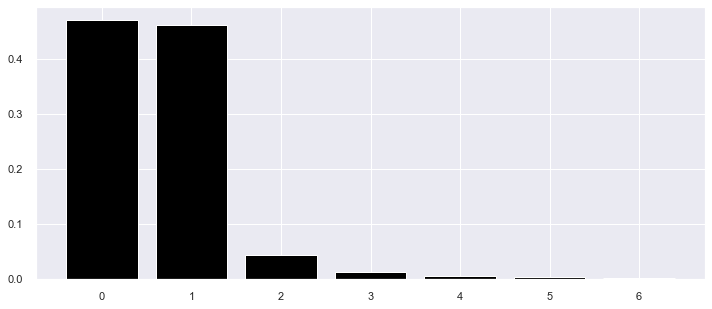

In [76]:
figure(figsize=(12,5))
pca = dd.PCA( n_components )
principal_components = pca.fit_transform(X)

# plot explain variable
features = range( pca.n_components )

plt.bar(features, pca.explained_variance_ratio_, color='black'); # os componentes principais com a maior variação dos dados: 0 e 1

# pca component
df_pca = pd.DataFrame( principal_components )

In [77]:
df_pca.head(2)

,0,1,2,3,4,5,6
0,0.765586,-0.437688,0.149525,-0.203219,0.964225,-0.082011,-0.000756
1,-0.019855,-0.069184,0.002816,-0.008566,-0.002683,0.002258,0.002201


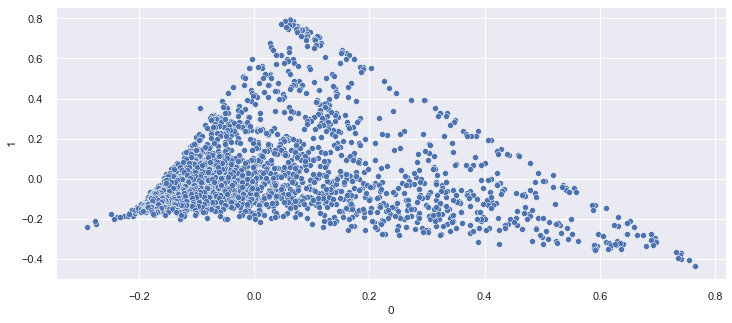

In [78]:
figure(figsize=(12,5))
sns.scatterplot( x=0, y=1, data=df_pca ); # mesmo plotando as features com maior variedade, nossos dados não se separam em clusters, portanto vamos tentar um novo espaço com UMAP

## 4.3.2. UMAP

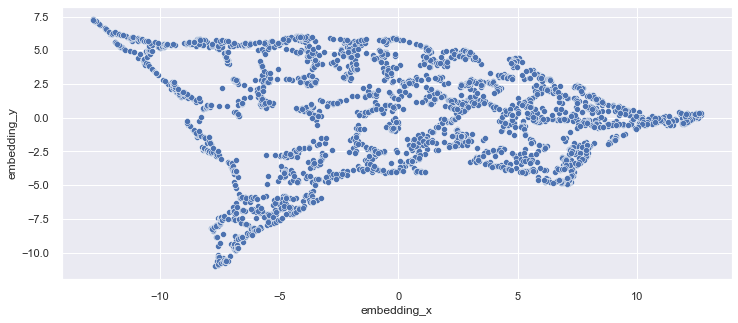

In [79]:
reducer = umap.UMAP( random_state = 42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
figure(figsize=(12,5))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data=df_pca );

## 4.3.3. t-SNE

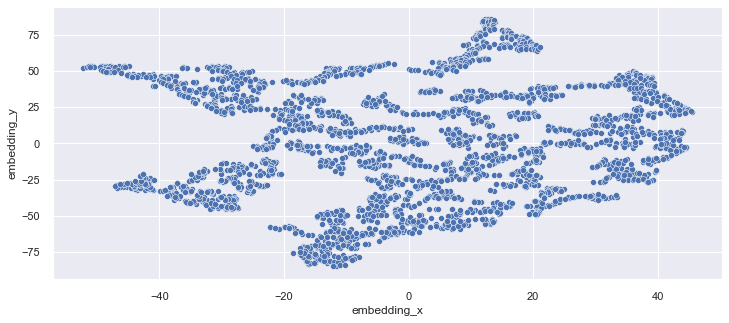

In [80]:
reducer = TSNE( n_components=2, n_jobs=-1, random_state = 42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
figure(figsize=(12,5))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data=df_pca );

## 4.3.4. Tree-based Embedding

In [82]:
# truque: hipótese que clientes que gastam mais são mais valiosos, portanto criaremos uma randomforest com a variável target Gross Revenue para definirmos um espaço
# na randomforest não precisamos do minmaxscaler

# training dataset
X = df4.drop(['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y ) # no fit eu montei a estrutura da árvore, agora como não queremos prever o y (que seria o predict), vamos aplicar a estrutura da árvore para todos meus dados de treinotemos um y para prever

# Leaf

# dataframe leaf

RandomForestRegressor(random_state=42)

In [83]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [84]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2950,3057,3099,2903,2837,2934,3038,3001,2956,3048,3037,3075,3120,2902,2792,3074,2805,2880,3114,2807,2881,2881,2918,2839,3014,2897,2762,2997,3019,2865,3138,2941,2908,2985,2960,2826,2843,2887,3016,2852,2908,3128,2947,2869,3086,2941,2998,2876,2962,2928,3005,2918,2783,2893,3056,3084,3044,2974,3077,2919,3116,2906,2899,2975,2897,3012,2946,3063,2878,3042,3048,3175,2933,2999,2920,2947,2948,2901,3132,2985,2798,3008,2930,2894,3076,3080,2936,2945,2948,2951,3002,2804,2776,3100,3060,3153,2842,2912,2764,2908
1,2765,2951,2723,2851,2833,2646,2696,2661,2899,2570,2569,2707,2707,2613,2621,2685,2692,2822,2682,2767,2872,2717,2858,2594,2636,2885,2470,2541,2661,2607,2525,2884,2869,2924,2678,2846,2598,2890,2627,2802,2641,2655,2704,2657,2683,2592,2685,2803,2685,2755,2548,2554,2776,2487,2628,2596,2991,2604,2752,2689,2753,2659,2633,2765,2852,2622,2860,2661,2848,2657,2564,2720,2630,2588,2888,2596,2719,2491,2745,2636,2683,2590,2606,2888,2780,2659,2856,2877,2640,2539,2572,2796,2772,2702,2686,2569,2789,2855,2572,2719
2,3365,3344,3360,3372,3305,3395,3376,3342,3360,3292,3341,3313,3339,3405,3251,3332,3307,3416,3396,3231,3391,3302,3312,3339,3397,3334,3216,3359,3306,3427,3398,3403,3397,3335,3323,3352,3334,3323,3312,3246,3388,3388,3408,3318,3367,3328,3324,3283,3451,3311,3318,3407,3278,3304,3347,3341,3322,3439,3235,3323,3376,3288,3312,3424,3352,3245,3367,3370,3323,3351,3385,3430,3410,3353,3334,3335,3344,3313,3449,3264,3280,3346,3351,3335,3308,3402,3348,3376,3324,3337,3386,3330,3346,3218,3342,3313,3326,3278,3315,3314
3,1282,1714,2005,1276,1163,1285,1883,1964,1344,1331,1558,1557,1322,1251,1529,1190,1303,2009,1273,1676,1622,1301,1586,1371,1833,1543,1312,1826,1718,1946,1645,1576,1309,1892,1347,1632,1189,1493,1272,1567,1363,2124,1368,1613,1319,1473,1278,1294,1520,1321,1548,1274,1636,1248,1344,1922,1672,2023,1337,2038,1603,1248,1442,1471,1729,1124,1612,1834,1655,1468,1829,1361,1372,1383,1475,1529,1345,1610,1586,1348,1324,1245,2015,1872,1357,1338,1538,1395,1286,1355,1795,1312,1279,1311,1339,1567,1292,1329,1585,1534
4,172,482,540,745,414,221,605,135,709,674,568,409,467,539,301,522,655,543,685,411,566,444,575,216,463,432,105,127,457,542,500,545,791,471,235,413,495,448,309,525,434,333,463,546,475,382,593,581,443,599,561,569,463,694,193,465,564,125,338,531,425,671,571,541,466,569,503,602,459,749,546,565,487,717,459,459,680,526,413,422,478,166,681,666,717,558,415,776,113,756,491,424,588,354,150,448,555,625,581,495


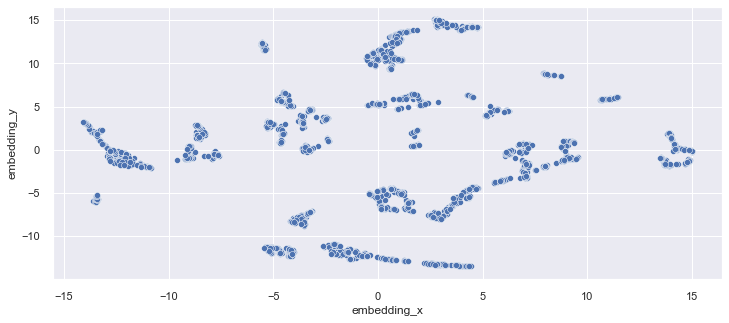

In [85]:
reducer = umap.UMAP( random_state = 42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
figure(figsize=(12,5))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data=df_pca );

## 5.0. Data Preparation

## 6.0. Feature Selection

## 7.0. Hyperparameter Fine-Tuning

In [ ]:
df7 = df5.copy()
df7.head()

In [ ]:
X = df7.drop('customer_id', axis=1)

In [ ]:
clusters = [2, 3, 4, 5, 6]

## 7.1. Within-Cluster Sum of Square (WSS)

In [ ]:
wss = []
for k in clusters:
    
    #model definition
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42  ) #init random significa que o modelo vai começar aleatoriamente procurando grupos com um centroide específico, deixamos n_init = 10 pra ele fazer 10x e não pegar o primeiro que pode não representar um bom cluster
    
    #model training
    kmeans.fit( X )
    
    #validation
    wss.append(kmeans.inertia_)
    
# plot wss - Elbow Method
figure(figsize=(10,6))
plt.plot( clusters, wss, linestyle='--', marker='o' );
plt.xlabel( 'K' );
plt.ylabel( 'Within-Cluster Sum of Square' );
plt.title( 'WSS vs K' );

In [ ]:
# outra forma de encontrar o k pelo WSS
figure(figsize=(10,6))
kmeans = KElbowVisualizer( c.KMeans(), k = clusters, timings=False )
kmeans.fit( X )
kmeans.show()

## 7.2. Silhouette Score

In [ ]:
figure(figsize=(10,6))
kmeans = KElbowVisualizer( c.KMeans(), k = clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

# quanto mais próximo a silhouette de 1, melhor. Significa que os clusters estão distantes entre si

## 7.3. Silhouette Analysis

In [ ]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 20) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod(k, 2) # q é linha e mod é a coluna; 2 é o mín entre nossos valores (moda é o resto) k (p/ k=2) divido por 2 dá 1 e o resto é zero [1][0]; k (p/ k=3) dividido por 2 dá 1 e o resto 1 [1][1]
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

## 8.0. Model Training

### 8.1. K-Means

In [ ]:
# model definition
k = 2
kmeans = c.KMeans(init = 'random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
#labels = kmeans.predict(X)
labels = kmeans.labels_

### 8.2. Cluster Validation

In [ ]:
# WSS Within-Cluster Sum of Square
print(f'WSS: {kmeans.inertia_}')

# SS Silhouette Score
print('SS: {}'.format( m.silhouette_score(X, labels, metric='euclidean') ))

## 9.0. Cluster Analysis

In [ ]:
df9 = df7.copy()

In [ ]:
df9['cluster'] = labels
df9.head()

### 9.1. Visualization Inspection

In [ ]:
# é possível apenas com 3 features

#fig = px.scatter_3d(df9, x='recency_in_days', y='frequency', z='gross_revenue', color='cluster')
#fig.show()

In [ ]:
k = 2
figure(figsize=(15,6))

km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
visualizer = SilhouetteVisualizer( km, color='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

### 9.2. 2d plot

In [ ]:
df9.head()

In [ ]:
df_viz = df9.drop('customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### 9.3. Cluster Profile

In [ ]:
# Number of clusters
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer_%'] = round((df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100,2)

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index() 
df_cluster = df_cluster.merge(df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency day
df_avg_recency_day = df9[['recency_in_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_recency_day, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_ticket, how='inner', on='cluster')

df_cluster

**Cluster 0**
1. x% na base
2. Clientes já gastaram em média $ x
3. Clientes ficam em média x meses sem comprar
4. Já compraram x produtos
5. Tem ticket médio de x

**Cluster 1 (Candidatos ao Insider)**
1. x
2. x
3. x
4. x

**Cluster 2**
1. x
2. x
3. x
4. x

## 10.0. Deploy